Simulated annealing basically emulates how nature finds the minimum energy state of a system as temperature drops.

We may use this algorithm to find the minimum (or the maximum) of a function stochastically. 

In [1]:
import numpy as np

import matplotlib
#matplotlib.use('WebAgg')
#matplotlib.use('Qt4Cairo')
#matplotlib.use('Qt5Cairo')
matplotlib.use('nbAgg')
import matplotlib.pyplot as plt

In [2]:
class SimulatedAnnealing:
    def __init__(self, func, region, x0, T0, sigma):
        '''
        func: the function to be minimized
                
        region: the search region
        
        x0: starting point
        
        k: to be used for the temperature update
        
        sigma: new neighbours are found between x+N(0,sigma)
        '''
        
        self.func=func
        self.region=region
        self.x=x0
        self.T=T0
        
        #sigma must be smaller than (region[d][1]- region[d][0])*2 
        self.sigma=sigma
        
        #dimension of the input
        self.dim=len(x0)
        #value of the function at x0 (so-called energy)
        self.E=self.func(x0)
        
        #use these to store the abolute minimum. At the end Emin and E should be close.
        self.E_min=self.E
        self.x_min=x0
        self.T0=T0
        
        
        self.ListProb=[]
        self.ListIC=[]
        self.ListE=[]
        self.ListEmin=[]
    
    
    def nextT(self,k):
        '''Update the temperature'''
#         self.T=self.T/(1+k*self.T)
        self.T*=k
        
    # we need the mod function to keep x in the search region in case sigma is too large 
    def mod(self,x,y):
        return float(x) - int(float(x)/float(y)) *float(y)
    def PickNeighbour(self):
        '''Pick a neighbour'''
        x=[]
        for d in range(self.dim):
            x.append(self.x[d] + np.random.rand()*self.sigma[d]-self.sigma[d]/2)
            
            if self.region[d][1]<x[d] :
                dx=x[d]-self.region[d][1]          
                dx=self.mod(dx,self.region[d][1]-self.region[d][0])
                x[d]=self.region[d][0] + dx
                
            if x[d] <self.region[d][0] :
                dx= self.region[d][0] - x[d]
                dx=  self.mod(dx,self.region[d][1]-self.region[d][0]) 
                x[d]= self.region[d][1] - dx

                
        x=np.array(x)
        return x
            
    
    def BoltzmannP(self,Enew):
        '''Given a new value of the energy, return the Boltzmann factor'''
        return np.exp(-(Enew-self.E)/self.T)
    
        
    
    
    def runT(self,IterationT):
        #use these to find the mean Delta E for a temperature 
        self.AccProb=0
        
        for _ in range(IterationT):
            xnew=self.PickNeighbour()
            Enew=self.func(xnew)
            
            #store the abolute minimum you've found so far
            if self.E<self.E_min:
                self.E_min=self.E
                self.x_min=self.x

            
            if Enew<self.E or self.BoltzmannP(Enew) > np.random.rand():
                self.AccProb+=1
                self.E=Enew
                self.x=xnew
                
        self.AccProb=self.AccProb/IterationT
    
        
    def InitT(self, IterationT, N0, k0, p0):
        '''Find an appropriace initial temperature'''
        IterT0=0
        
        while IterT0<N0:
            self.runT(IterationT)
           
            if self.AccProb>p0:
                IterT0+=1
            
            if self.AccProb<p0 and IterT0>0:
                IterT0=0
            
            self.T*=k0
                

        
       
    def run(self, CList, tol, MinT,k=1-1e-2, Nstar=5000, IterationT=100,
            N0=500, k0=1+1e-2, p0=0.8):
        '''
        Iterate until the temperature reaches MinT or until it reaches convergence (Nstart times with AccProb<tol)
        CList=True stores acceptance probabilities, IterConv, E values for all temperatures 
        in self.ListProb self.ListIC, self.ListE

        tol,Nstar: SA Stops when the acceptance probability is below tol for Nstar successive iterations
        IterationT: number of iterations per temperature
        MinT:  stop when the temperature becomes MinT
        
        To initialize the temperature:
        p0,N0,k0: increase the temperature as T->T*k0 until the acceptance probability is larger that p0
        for N0 successive iterations
        
        If N0=0, then run with T0. If N0!=0, initialize T0 by running InitT. Since T0 is attribute of this class
        you can first run with N0>0, and then run again with N0=0. During the first run, a suitable T0 will be found,
        so that you'll not have to do it again!
        '''
        if N0==0:
            self.T=self.T0;
        else:
            self.InitT(IterationT, N0, k0, p0)
            self.T0=self.T;
        
        IterConv=0
        
        
        
        self.points=[]
        while self.T>MinT and Nstar>IterConv:
            self.runT(IterationT)

            if self.AccProb<tol:
                IterConv+=1
                self.points.append(self.x)
            
            if self.AccProb>tol and IterConv>0:
                IterConv=0
                self.points=[]
            
            
            if CList:
                self.ListProb.append(self.AccProb)
                self.ListIC.append(IterConv)
                self.ListE.append(self.E)
                self.ListEmin.append(self.E_min)
            
            
            
            self.nextT(k)
            
        self.points=np.array(self.points)
        self.x,self.E= self.x_min,self.E_min
        return self.x,self.E
    
                        

In [3]:
def f(x):
#     return (x[0]-3)**4+(x[1]-1)**2+(x[2]+50)**2
    return (3-x[0])**2+300*(x[1]-x[0]**2)**2
#     return -np.exp(-(x[0]-1)**2)*np.sin(np.pi*x[0])*5+2
#     return np.sum(x**2)



In [4]:
#a good approach is to run once with a large sigma, and once it 
# converges run with a smaller one starting from the last point
# and a higher temperature.

region=[[-10,10] for  _ in range(2)]

dim=len(region)


#first run
x0= np.random.rand(dim)*5-2.5
k=1-5e-3
T0=np.abs(f(x0))*10+1
IterationT=50
MinT=0#1e-50
sigma=[1e0 for d in range(dim)]
tol=1e-3
Nstar=50

p0=0.8
N0=100
k0=1.1

SA=SimulatedAnnealing(f,region,x0,T0,sigma)
print(SA.run(True, tol, MinT,k, Nstar, IterationT,N0,k0,p0),
      '\n\n T=',
       SA.T)

SA.IterationT=150
SA.k=0.99
SA.sigma=[1e-2 for d in range(dim)]
print(SA.run(True,tol, MinT,k, Nstar, IterationT,0),
      '\n\n T=',
       SA.T)

(array([2.99755843, 8.98537441]), 6.057337079761517e-06) 

 T= 0.0006496146125560799
(array([3.00012936, 9.00077146]), 2.3408268812505502e-08) 

 T= 1.025559129841162e-06


<IPython.core.display.Javascript object>


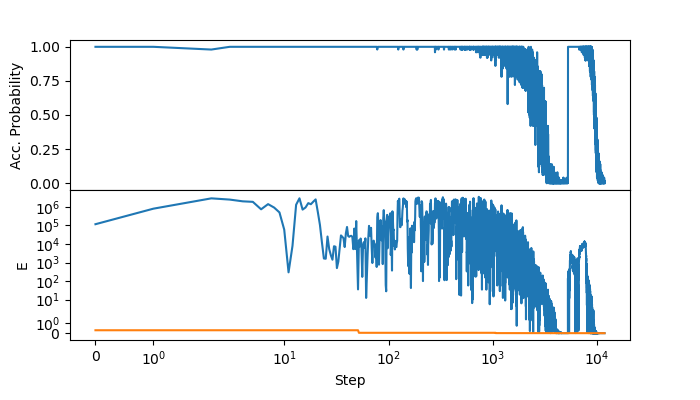

In [5]:
fig=plt.figure(figsize=(7,4))
fig.subplots_adjust(bottom=0.15, left=0.1, top = 0.9, right=0.9,wspace=0.1,hspace=0)
#=============================================================================#


sub = fig.add_subplot(211)
sub.plot(SA.ListProb)

sub.set_xscale('symlog')
# sub.set_yscale('symlog')
sub.set_ylabel('Acc. Probability')
sub.get_xaxis().set_visible(False)


sub = fig.add_subplot(212)
sub.plot(SA.ListE)
sub.plot(SA.ListEmin)

sub.set_xscale('symlog')
sub.set_yscale('symlog')



sub.set_xlabel('Step')
sub.set_ylabel('E')


plt.show()